## Group assignment

In [ ]:
pip install rdkit-pypi

### loading data

In [114]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [77]:
file_path = './tested_molecules.csv'
data = pd.read_csv(file_path)

# Convert inhibition columns to integers
data["PKM2_inhibition"] = data["PKM2_inhibition"].astype(int)
data["ERK2_inhibition"] = data["ERK2_inhibition"].astype(int)
data

,SMILES,PKM2_inhibition,ERK2_inhibition
0,C=C(C)c1nc(N)nc(N)n1,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0
...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,0,1
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,0,1
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,0,1
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,0,1


### Calculating some molecular descriptions

In [78]:
#Physicochemical properties
# Function to compute molecular properties
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol_weight = Descriptors.MolWt(mol)
        h_bond_acceptors = int(Descriptors.NumHAcceptors(mol))
        h_bond_donors = int(Descriptors.NumHDonors(mol))
        tpsa = Descriptors.TPSA(mol)
        return pd.Series([mol_weight, h_bond_acceptors, h_bond_donors, tpsa])
    else:
        return pd.Series([None, None, None, None])

# Apply the function to the 'SMILES' column
data[['molecular_weight', 'h_bond_acceptors', 'h_bond_donors', 'TPSA']] = data['SMILES'].apply(compute_properties)

# Ensure proper integer data types for the hydrogen bond columns
data['h_bond_acceptors'] = data['h_bond_acceptors'].astype(pd.Int64Dtype())
data['h_bond_donors'] = data['h_bond_donors'].astype(pd.Int64Dtype())

In [79]:
#Counters of pre-defined substructures
def num_aromatic_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        aromatic_rings = 0
        for ring in mol.GetRingInfo().AtomRings():
            if all(mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in ring):
                aromatic_rings += 1
        return aromatic_rings
    return None

def num_rotatable_bonds(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return rdMolDescriptors.CalcNumRotatableBonds(mol)
    return None

#applying functions to dataframe
data['num_aromatic_rings'] = data['SMILES'].apply(num_aromatic_rings)
data['num_rotatable_bonds'] = data['SMILES'].apply(num_rotatable_bonds)
data

,SMILES,PKM2_inhibition,ERK2_inhibition,molecular_weight,h_bond_acceptors,h_bond_donors,TPSA,num_aromatic_rings,num_rotatable_bonds
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,5,2,90.71,1,1
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,3,0,39.44,2,3
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,2,2,58.20,0,8
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,4,0,58.17,2,3
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,4,0,44.00,1,4
...,...,...,...,...,...,...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,0,1,362.385,5,1,63.94,3,4
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,0,1,374.442,4,1,64.72,4,4
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,0,1,355.849,4,2,53.69,3,3
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,0,1,322.437,5,0,32.26,3,3


In [130]:
#Binary fingerprints
# Function to compute Morgan fingerprint
def compute_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return list(fp)  # Convert to list for easier handling
    else:
        return None

# Function to compute MACCS keys
def compute_maccs_keys(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        keys = MACCSkeys.GenMACCSKeys(mol)
        return list(keys)  # Convert to list for easier handling
    else:
        return None

# Apply functions to the SMILES column and create new columns
data['Morgan_Fingerprint'] = data['SMILES'].apply(compute_morgan_fp)
data['MACCS_Keys'] = data['SMILES'].apply(compute_maccs_keys)

In [118]:

print(len(data.iloc[0, 9]))

2048


## Exploratory data analysis

### PCA

In [124]:
fingerprints_df_M = pd.DataFrame(data['Morgan_Fingerprint'].tolist())
fingerprints_df_K = pd.DataFrame(data['MACCS_Keys'].tolist())

combined_df = pd.concat([data.drop(columns=['SMILES', 'Morgan_Fingerprint', 'MACCS_Keys', 'PKM2_inhibition', 'ERK2_inhibition']), fingerprints_df_M, fingerprints_df_K], axis=1)

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(combined_df)

# Perform PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
principal_components = pca.fit_transform(standardized_data)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Combine with original data
final_df = pd.concat([data.drop(columns=['Morgan_Fingerprint', 'MACCS_Keys']), principal_df], axis=1)

# Display the final DataFrame
final_df

,SMILES,PKM2_inhibition,ERK2_inhibition,molecular_weight,h_bond_acceptors,h_bond_donors,TPSA,num_aromatic_rings,num_rotatable_bonds,PC1,PC2
0,C=C(C)c1nc(N)nc(N)n1,0,0,151.173,5,2,90.71,1,1,-5.717557,0.273388
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,250.681,3,0,39.44,2,3,-3.271652,7.155799
2,C=CCNC(=O)CCCC(=O)NCC=C,0,0,210.277,2,2,58.20,0,8,-1.703511,4.709587
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,232.239,4,0,58.17,2,3,-3.634770,0.475442
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,226.663,4,0,44.00,1,4,-2.725067,-1.123434
...,...,...,...,...,...,...,...,...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,0,1,362.385,5,1,63.94,3,4,-1.150214,1.077450
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,0,1,374.442,4,1,64.72,4,4,8.092819,-6.693983
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,0,1,355.849,4,2,53.69,3,3,-4.153069,-1.729367
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,0,1,322.437,5,0,32.26,3,3,-2.692586,-7.452452


In [126]:
#checking the variance of the first few principle components
cumulative_exp_var = list(explained_variance_ratio)
print(cumulative_exp_var[0])
print(cumulative_exp_var[1])


0.010917634274256719
0.019616419985904354


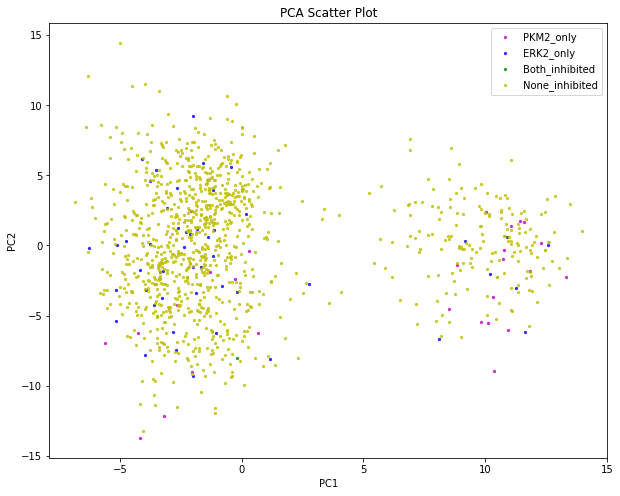

In [129]:
scores_df = pd.DataFrame(final_df, columns=['PC1', 'PC2'])

# Create a new column for color labels
def get_color_label(row):
    if row['PKM2_inhibition'] == 1 and row['ERK2_inhibition'] == 0:
        return 'PKM2_only'
    elif row['PKM2_inhibition'] == 0 and row['ERK2_inhibition'] == 1:
        return 'ERK2_only'
    elif row['PKM2_inhibition'] == 1 and row['ERK2_inhibition'] == 1:
        return 'Both_inhibited'
    else:
        return 'None_inhibited'
    
final_df['Color'] = final_df.apply(get_color_label, axis=1)

color_map = {
    'PKM2_only': 'm', 
    'ERK2_only': 'blue',
    'Both_inhibited': 'green',
    'None_inhibited': 'y'
}

# Scatter plot
plt.figure(figsize=(10, 8))
for color_label, color in color_map.items():
    subset = final_df[final_df['Color'] == color_label]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=color_label, s=5, alpha =0.75)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

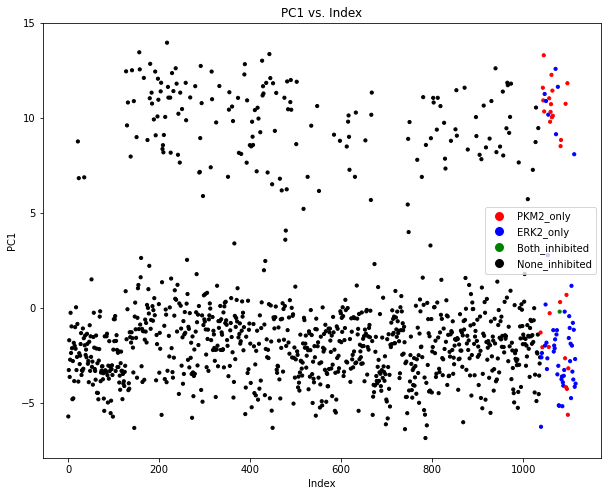

In [131]:
# Define colors for the scatter plot based on inhibition status
def get_color(row):
    if row['PKM2_inhibition'] == 1 and row['ERK2_inhibition'] == 0:
        return 'red'
    elif row['PKM2_inhibition'] == 0 and row['ERK2_inhibition'] == 1:
        return 'blue'
    elif row['PKM2_inhibition'] == 1 and row['ERK2_inhibition'] == 1:
        return 'green'
    else:
        return 'black'

final_df['Color'] = final_df.apply(get_color, axis=1)


# Scatter plot of PC1 vs. Index
plt.figure(figsize=(10, 8))
plt.scatter(final_df.index, final_df['PC1'], c=final_df['Color'], s =10)

# plt.figure(figsize=(10, 8))
# for color_label, color in color_map.items():
#     print(color_label, color)
#     subset = final_df[final_df['Color'] == color_label]
#     plt.scatter(subset.index, subset['PC1'], c=color, label=color_label, s=5)


# Define the legend manually
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='PKM2_only'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ERK2_only'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Both_inhibited'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='None_inhibited')
]
plt.legend(handles=handles)

plt.xlabel('Index')
plt.ylabel('PC1')
plt.title('PC1 vs. Index')
plt.show()

In [121]:
pc1_loadings = pca.components_[0]  # Extract loadings for PC1 (first principal component)

# Map loadings to the columns in combined_df
feature_names = list(combined_df.columns)
loadings_df = pd.DataFrame({'Feature': feature_names, 'Loading_PC1': pc1_loadings})
loadings_df

# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(loadings_df)

# Sort by absolute value of Loading_PC1 to identify most important features
loadings_df['Abs_Loading_PC1'] = abs(loadings_df['Loading_PC1'])
loadings_df = loadings_df.sort_values(by='Abs_Loading_PC1', ascending=False)

# Display the most important features for PC1
print("Top features contributing to PC1:")
print(loadings_df[['Feature', 'Loading_PC1', 'Abs_Loading_PC1']].head(10))

                  Feature  Loading_PC1
0        molecular_weight    7.367e-02
1        h_bond_acceptors    1.795e-02
2           h_bond_donors   -1.580e-02
3                    TPSA    6.424e-02
4      num_aromatic_rings   -1.554e-02
5     num_rotatable_bonds    6.588e-02
6                       0    7.512e-03
7                       1   -7.689e-03
8                       2    1.422e-02
9                       3   -9.394e-03
10                      4    4.064e-02
11                      5   -2.347e-03
12                      6   -6.802e-03
13                      7    1.383e-03
14                      8    1.450e-02
15                      9   -1.178e-02
16                     10   -5.920e-03
17                     11    6.184e-03
18                     12   -6.915e-03
19                     13    3.355e-03
20                     14    1.534e-02
21                     15   -6.664e-03
22                     16   -2.111e-03
23                     17    1.731e-03
24                     18

In [122]:
pc2_loadings = pca.components_[1]  # Extract loadings for PC1 (first principal component)

# Map loadings to the columns in combined_df
feature_names = list(combined_df.columns)
loadings_df = pd.DataFrame({'Feature': feature_names, 'Loading_PC2': pc2_loadings})
loadings_df

# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(loadings_df)

# Sort by absolute value of Loading_PC1 to identify most important features
loadings_df['Abs_Loading_PC2'] = abs(loadings_df['Loading_PC2'])
loadings_df = loadings_df.sort_values(by='Abs_Loading_PC2', ascending=False)

# Display the most important features for PC1
print("Top features contributing to PC2:")
print(loadings_df[['Feature', 'Loading_PC2', 'Abs_Loading_PC2']].head(10))

                  Feature  Loading_PC2
0        molecular_weight   -3.228e-02
1        h_bond_acceptors   -9.358e-02
2           h_bond_donors    4.134e-02
3                    TPSA   -9.480e-04
4      num_aromatic_rings   -1.389e-01
5     num_rotatable_bonds    9.813e-03
6                       0   -1.166e-02
7                       1    1.201e-02
8                       2    6.857e-03
9                       3   -2.404e-02
10                      4   -8.231e-03
11                      5    3.023e-02
12                      6    1.388e-02
13                      7    6.032e-03
14                      8    1.697e-06
15                      9    2.158e-02
16                     10   -2.042e-03
17                     11    2.006e-03
18                     12    3.963e-03
19                     13    3.794e-02
20                     14   -3.701e-02
21                     15    1.224e-02
22                     16   -4.463e-03
23                     17    9.731e-03
24                     18

### Visualisation correlation and fingerprint analysis

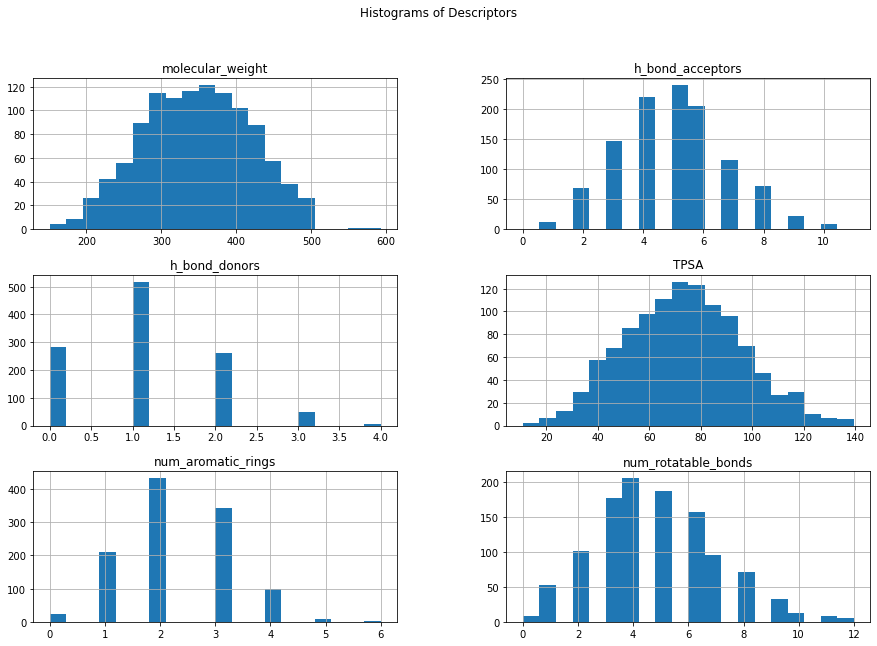

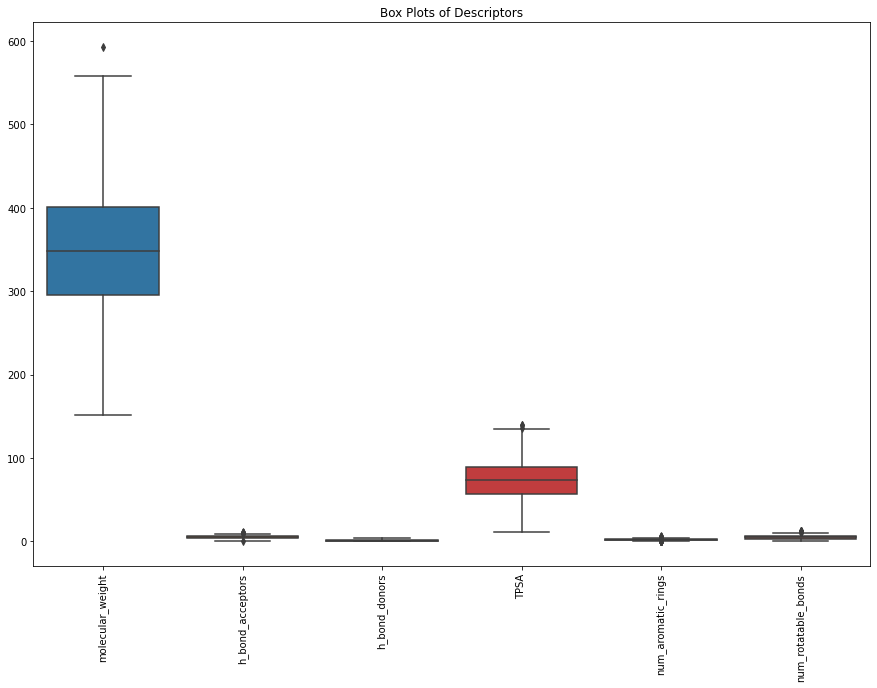

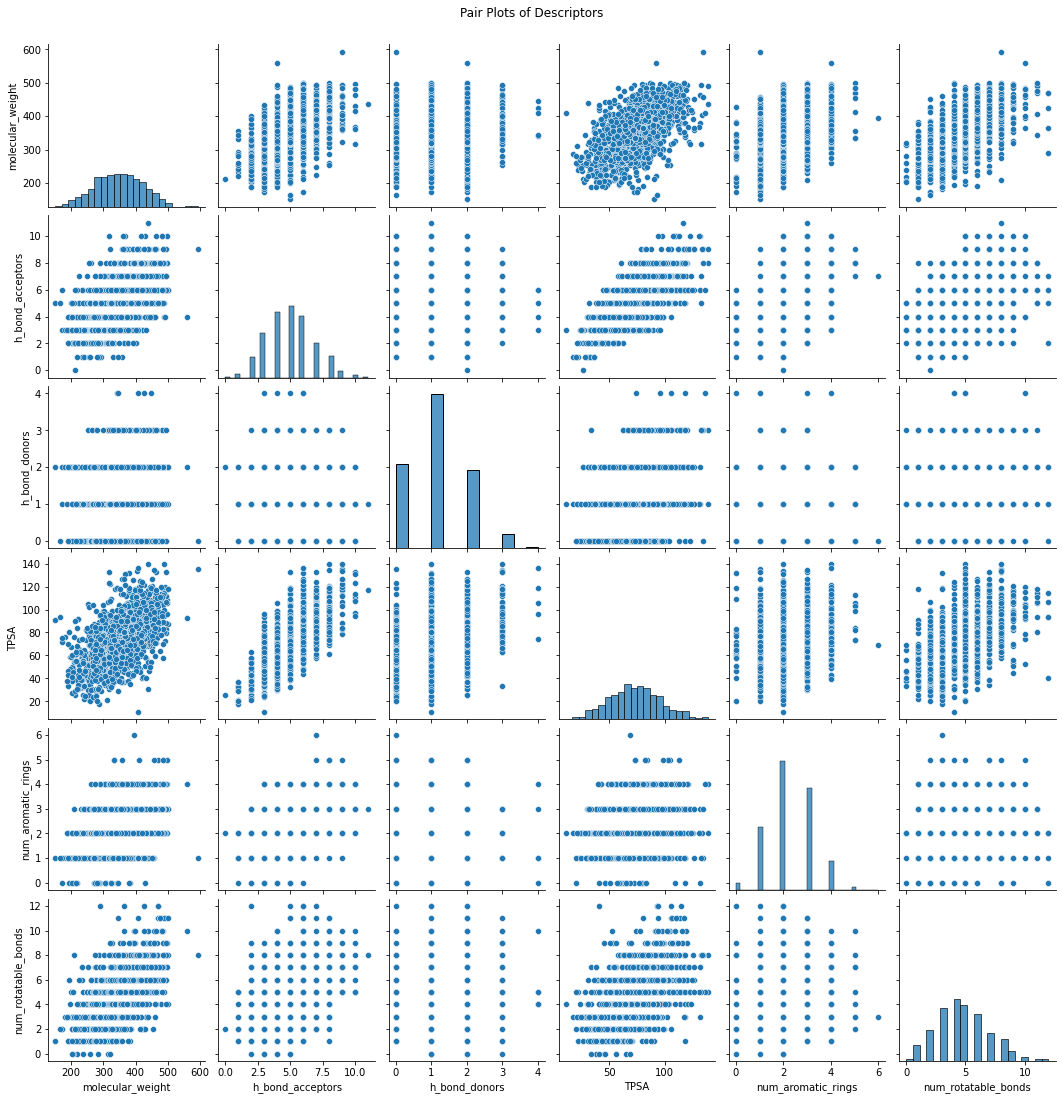

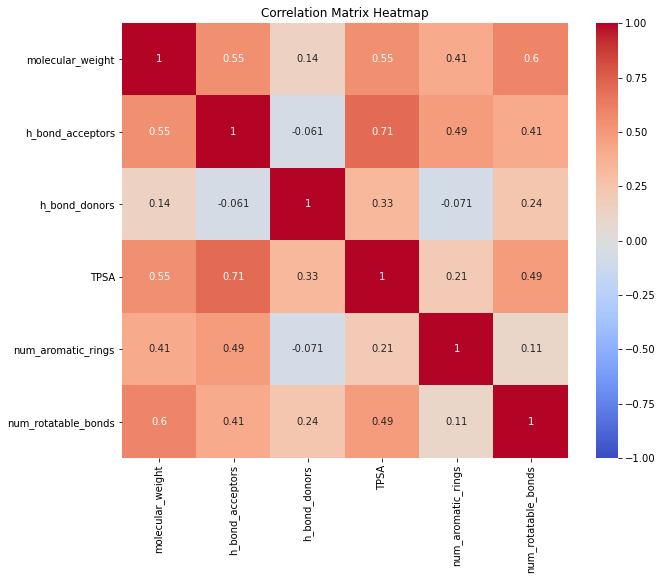

In [132]:
# Select relevant columns (descriptors)
descriptors = data.iloc[:, 3:11]

# Data Preprocessing
# Check for missing values
missing_values = descriptors.isnull().sum()

# Summary Statistics
summary_stats = descriptors.describe()

# Correlation Matrix
correlation_matrix = descriptors.corr()

# Visualizations
# Histograms
descriptors.hist(bins=20, figsize=(15, 10))
plt.suptitle('Histograms of Descriptors')
plt.show()

# Box plots
plt.figure(figsize=(15, 10))
sns.boxplot(data=descriptors)
plt.title('Box Plots of Descriptors')
plt.xticks(rotation=90)
plt.show()

# Pair plots
sns.pairplot(descriptors)
plt.suptitle('Pair Plots of Descriptors', y=1.02)
plt.show()

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

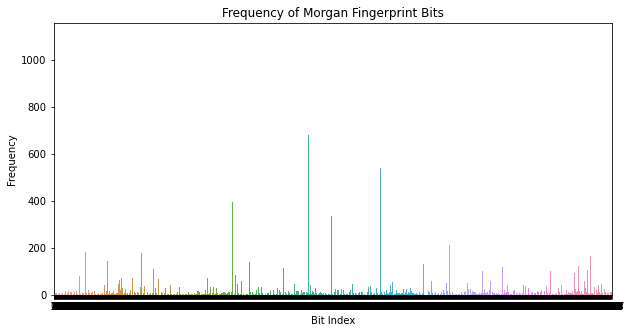

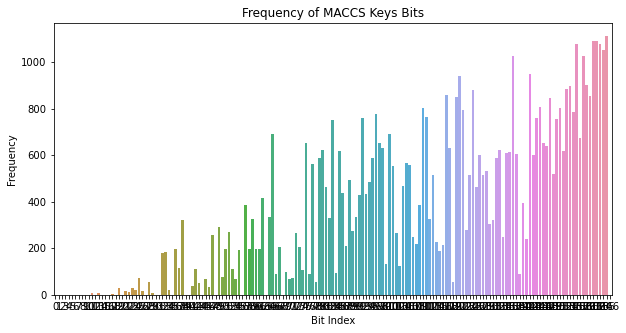

In [133]:
# Fingerprint Analysis
# Convert fingerprints to DataFrame for analysis
morgan_fp_df = pd.DataFrame(data['Morgan_Fingerprint'].tolist())
maccs_keys_df = pd.DataFrame(data['MACCS_Keys'].tolist())

# Frequency analysis of Morgan Fingerprint bits
morgan_fp_freq = morgan_fp_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=morgan_fp_freq.index, y=morgan_fp_freq.values)
plt.title('Frequency of Morgan Fingerprint Bits')
plt.xlabel('Bit Index')
plt.ylabel('Frequency')
plt.show()

# Frequency analysis of MACCS Keys bits
maccs_keys_freq = maccs_keys_df.sum().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=maccs_keys_freq.index, y=maccs_keys_freq.values)
plt.title('Frequency of MACCS Keys Bits')
plt.xlabel('Bit Index')
plt.ylabel('Frequency')
plt.show()